In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import IsolationForest
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support, mean_squared_error, recall_score
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

## Dataset

In [2]:
# Read training and test data
processed_data_dir = 'data'
X_train_path = os.path.join(processed_data_dir, 'X_train.csv')
y_train_path = os.path.join(processed_data_dir, 'y_train.csv')
X_test_path = os.path.join(processed_data_dir, 'X_test.csv')
y_test_path = os.path.join(processed_data_dir, 'y_test.csv')

X_train = pd.read_csv(X_train_path)
y_train = pd.read_csv(y_train_path)
X_test = pd.read_csv(X_test_path)
y_test = pd.read_csv(y_test_path)

# Algorithms

In [3]:
# Create a results dataframe to store and later compare results
results = pd.DataFrame()
results['Metrics'] = ['True Negatives', 'False Negatives', 'False Positives', 'True Positives', 'Accuracy', 'Precision', 'Recall', 'F1-Score', 'Support']

def get_metrics(labels, pred_labels):
    conf_matrix = np.asarray(confusion_matrix(labels, pred_labels))
    metrics = np.concatenate(([accuracy_score(labels, pred_labels)], precision_recall_fscore_support(labels, pred_labels, average='binary')))
    return np.concatenate((conf_matrix.reshape(-1),metrics))

def fit_model(input_data, model_fn, model_args=None, threshold=None, labels=None):
    return model_fn(input_data, model_args, threshold, labels)

def predict_model(input_data, model, predict_fn, threshold=None):
    return predict_fn(input_data, model, threshold)

## Isolation Forest

In [4]:
def fit_isolation_forest(input_data, args=None, threshold=None, labels=None):
    if threshold == None:
        model = IsolationForest()
    else:
        model = IsolationForest(contamination=threshold)
    
    model.fit(input_data)

    return model

def predict_isolation_forest(input_data, model, threshold=None):
    y_pred = model.predict(input_data)
    y_pred = [1 if pred == -1 else 0 for pred in y_pred]

    return y_pred

In [5]:
if_model = fit_model(X_train, fit_isolation_forest, None)

y_pred_test = predict_model(X_test, if_model, predict_isolation_forest)
print('CONFUSION MATRIX:\n', confusion_matrix(y_test,y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test))

CONFUSION MATRIX:
 [[495  30]
 [  5  85]]
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.94      0.97       525
           1       0.74      0.94      0.83        90

    accuracy                           0.94       615
   macro avg       0.86      0.94      0.90       615
weighted avg       0.95      0.94      0.95       615



In [6]:
results['Isolation Forest'] = get_metrics(y_test, y_pred_test)

## Local Outlier Factor

#### Dataset Distribution (Outlier and Novelty detection)

We have to distribute the datasets in two different ways in order to perform both outlier and novelty detection. 

For **Outlier Detection** dataset we are going to concat train and test set since this methods run predictions over the same data. 

For **Novelty Detection** dataset we need to remove all fraud samples from the training set and put them on the test set.

In [7]:
Xy_train = pd.concat([X_train, y_train], axis=1)
Xy_test = pd.concat([X_test, y_test], axis=1)

# Outlier-detection Dataset
X_out_train = pd.concat([Xy_train, Xy_test], axis=0)
y_out_train = pd.DataFrame(X_out_train['isFradulent'])
X_out_train.drop('isFradulent', axis='columns', inplace= True)

# Novelty-detection Dataset
X_nov_train = Xy_train[Xy_train['isFradulent'] == 0].copy()
X_nov_train.drop('isFradulent', axis='columns', inplace= True)
X_nov_train_val = Xy_train.drop('isFradulent', axis='columns', inplace= False)
y_nov_train_val = y_train

print('X_train', str(len(X_train)))
print('X_nov_train', str(len(X_nov_train)))
print('X_out_train', str(len(X_out_train)))
print('y_out_train', str(len(y_out_train)))
print('X_test', str(len(X_test)))
print('y_test', str(len(y_test)))

X_train 2460
X_nov_train 2102
X_out_train 3075
y_out_train 3075
X_test 615
y_test 615


### Training

In [8]:
# Calculate outlier_fraction value to be sent as contamination parameter
no_fraud = len(y_out_train[y_out_train['isFradulent'] == 1])
no_valid = len(y_out_train) - no_fraud

outlier_fraction = no_fraud/float(no_valid)

print('X_train len: ',len(X_out_train))
print('y_train len: ',len(y_out_train))
print('total: ',no_fraud+no_valid)
print('no_fraud: ',no_fraud)
print('no_valid: ',no_valid)
print('Outlier Fraction: ',outlier_fraction)

X_train len:  3075
y_train len:  3075
total:  3075
no_fraud:  448
no_valid:  2627
Outlier Fraction:  0.1705367339170156


#### Outlier Detection

In [9]:
lof_model = LocalOutlierFactor(n_neighbors = 20,contamination = outlier_fraction, novelty=False)

y_prediction1 = lof_model.fit_predict(X_out_train) # Fitting the model.

y_prediction1[y_prediction1 == 1] = 0 # Valid transactions are labelled as 0.
y_prediction1[y_prediction1 == -1] = 1 # Fraudulent transactions are labelled as 1.

print('CLASSIFICATION RESULTS')
print(classification_report(y_out_train,y_prediction1))

CLASSIFICATION RESULTS
              precision    recall  f1-score   support

           0       0.91      0.88      0.89      2627
           1       0.40      0.46      0.43       448

    accuracy                           0.82      3075
   macro avg       0.65      0.67      0.66      3075
weighted avg       0.83      0.82      0.82      3075



#### Novelty Detection

In [10]:
def fit_local_outlier_factor(input_data, args, threshold=None, labels=None):
    Xy_input = pd.concat([input_data, labels], axis=1)
    X_no_fraud = Xy_input[Xy_input['isFradulent'] == 0].copy()
    X_no_fraud.drop('isFradulent', axis='columns', inplace= True)

    if threshold == None:
        no_fraud = len(labels[labels['isFradulent'] == 1])
        no_valid = len(labels) - no_fraud
        outlier_fraction = no_fraud/float(no_valid)

        model = LocalOutlierFactor(n_neighbors=args[0], contamination=outlier_fraction, novelty=True)
    else:
        model = LocalOutlierFactor(n_neighbors=args[0], contamination=threshold, novelty=True)
    
    model.fit(X_no_fraud)

    return model

def predict_local_outlier_factor(input_data, model, threshold=None):
    y_prediction = model.predict(input_data)
    y_prediction[y_prediction == 1] = 0 # Valid transactions are labelled as 0.
    y_prediction[y_prediction == -1] = 1 # Fraudulent transactions are labelled as 1.

    return y_prediction

In [11]:
lof_model = fit_model(X_train, fit_local_outlier_factor, model_args=[20], labels=y_train)

y_pred_test = predict_model(X_test, lof_model, predict_local_outlier_factor)
print('CONFUSION MATRIX:\n', confusion_matrix(y_test, y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test))

CONFUSION MATRIX:
 [[418 107]
 [ 20  70]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.80      0.87       525
           1       0.40      0.78      0.52        90

    accuracy                           0.79       615
   macro avg       0.67      0.79      0.70       615
weighted avg       0.87      0.79      0.82       615



**Note:** We will only use the Novelty Detection results, since we want to compare results over the same test data and we only can run prediction with outlier detection over the training data.

In [12]:
results['LOF Novelty Detection'] = get_metrics(y_test,y_pred_test)

## Gaussian Mixture

In [13]:
def fit_gaussian_mixture(input_data, args=None, threshold=None, labels=None):
    if threshold == None:
        model = GaussianMixture(n_components=2)
    else:
        model = GaussianMixture(n_components=2, reg_covar=threshold)
    
    model.fit(input_data)

    return model

def predict_gaussian_mixture(input_data, model, threshold=None):
    return model.predict(input_data)

In [14]:
gm_model = fit_model(X_train, fit_gaussian_mixture, None)

y_pred_test = predict_model(X_test, gm_model, predict_gaussian_mixture)
print('CONFUSION MATRIX:\n', confusion_matrix(y_test,y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test))

CONFUSION MATRIX:
 [[506  19]
 [ 27  63]]
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.96       525
           1       0.77      0.70      0.73        90

    accuracy                           0.93       615
   macro avg       0.86      0.83      0.84       615
weighted avg       0.92      0.93      0.92       615



In [15]:
results['Gaussian Mixture'] = get_metrics(y_test, y_pred_test)

## Autoencoders

In [16]:
def fit_autoencoder(input_data, args, threshold=None, labels=None):
    ss = StandardScaler()
    X_tscaled = ss.fit_transform(input_data.values)
    X_fit = pd.DataFrame(X_tscaled, columns=input_data.columns, index=input_data.index)

    # input
    inp = Input(shape=(X_fit.shape[1],))

    # Encoder
    x = Dense(100, activation='relu')(inp)
    x = Dense(50, activation='relu')(x)

    # Decoder
    x = Dense(50, activation='tanh')(x)
    x = Dense(100, activation='tanh')(x)

    ## output
    output = Dense(X_fit.shape[1], activation='relu')(x)

    autoencoder = Model(inp, output)

    lr = args[0]
    epochs = args[1]
    adam = Adam(lr=lr, decay=(lr/epochs))

    autoencoder.compile(optimizer=adam, loss="mean_squared_error")

    autoencoder.fit(X_fit.values, X_fit.values, batch_size=2048, epochs=epochs,
                          shuffle=True, verbose=0)
    encoder = Sequential()
    encoder.add(autoencoder.layers[0])
    encoder.add(autoencoder.layers[1])
    encoder.add(autoencoder.layers[2])

    decoder = Sequential()
    decoder.add(autoencoder.layers[3])
    decoder.add(autoencoder.layers[4])
    decoder.add(autoencoder.layers[5])

    return (encoder, decoder)

def get_autoencoder_rc_scores(input_data, model):
    ss = StandardScaler()
    X_tscaled = ss.fit_transform(input_data.values)
    X_fit = pd.DataFrame(X_tscaled, columns=input_data.columns, index=input_data.index)

    encoded_data = model[0].predict(X_fit)
    decoded_data = model[1].predict(encoded_data)

    decoded_df = pd.DataFrame(decoded_data, columns=X_fit.columns, index=X_fit.index)

    reconstruction_scores = []
    for idx in X_fit.index:
        score = mean_squared_error(X_fit.loc[idx], decoded_df.loc[idx])
        reconstruction_scores.append(score)
        
    rc_scores = pd.DataFrame(reconstruction_scores, index=X_fit.index, columns=['reconstruction_score']).sort_values(by='reconstruction_score', ascending=False)

    return rc_scores

def predict_autoencoder(input_data, model, threshold=None):
    rc_scores = get_autoencoder_rc_scores(input_data, model)

    if threshold == None:
        rec_median = rc_scores['reconstruction_score'].median()
        rec_std = rc_scores['reconstruction_score'].std()

        default_threshold = rec_median + 2*rec_std
        score_filter = rc_scores > default_threshold
    else:
        score_filter = rc_scores > threshold

    top_scores_idx = rc_scores[score_filter].dropna().index

    pred = np.zeros(len(input_data))
   
    for x in top_scores_idx:
        pred[x] = 1

    return pred

In [17]:
args = [0.0001, 300] # the fit function takes 2 arguments: lr (set to 0.0001) and epochs (set to 300)
ae_model = fit_model(X_train, fit_autoencoder, args)

y_pred_test = predict_model(X_test, ae_model, predict_autoencoder)
print('CONFUSION MATRIX:\n', confusion_matrix(y_test,y_pred_test))
print("Classification Report:\n", classification_report(y_test, y_pred_test))

CONFUSION MATRIX:
 [[524   1]
 [ 49  41]]
Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95       525
           1       0.98      0.46      0.62        90

    accuracy                           0.92       615
   macro avg       0.95      0.73      0.79       615
weighted avg       0.92      0.92      0.91       615



In [18]:
results['Autoencoders'] = get_metrics(y_test, y_pred_test)

# Training Results

In [19]:
results

,Metrics,Isolation Forest,LOF Novelty Detection,Gaussian Mixture,Autoencoders
0,True Negatives,495,418,506,524
1,False Negatives,30,107,19,1
2,False Positives,5,20,27,49
3,True Positives,85,70,63,41
4,Accuracy,0.943089,0.793496,0.925203,0.918699
5,Precision,0.73913,0.39548,0.768293,0.97619
6,Recall,0.944444,0.777778,0.7,0.455556
7,F1-Score,0.829268,0.524345,0.732558,0.621212
8,Support,None,None,None,None


In [20]:
def get_performance_curve(fit_data, predict_data, labels, threshold_range, predict_fn, model=None, model_fn=None, model_args=None):
    recall_list = []
    audit_ratio_list = []

    for i in threshold_range:
        if model == None:
            new_model = fit_model(fit_data, model_fn, model_args, i, labels)
        else:
            new_model = model
        
        y_pred = predict_model(predict_data, new_model, predict_fn, i)

        audit_ratio = sum(pred == 1 for pred in y_pred)/len(y_pred)

        recall_list.append(recall_score(labels, y_pred))
        audit_ratio_list.append(audit_ratio)
    
    performance_curve = pd.DataFrame()
    performance_curve['Audit ratio'] = audit_ratio_list
    performance_curve['Detected frauds ratio'] = recall_list

    return performance_curve.sort_values('Audit ratio')

ideal_curve = pd.DataFrame()
ideal_curve['Audit ratio'] = [0, 0.15, 1]
ideal_curve['Detected frauds ratio'] = [0, 1, 1]

def plot_all_performance_curves(isolation_forest_performance_curve, autoencoder_performance_curve, lof_performance_curve, gm_performance_curve, title):
    fig = plt.figure(figsize=(12, 8))
    ax = fig.add_subplot(1, 1, 1)
    plt.title(title)
    plt.xlabel('Audit ratio')
    plt.ylabel('Detected frauds ratio')

    plt.xlim(right=0.5)

    x_ticks = np.arange(0, 0.55, 0.05)
    y_ticks = np.arange(0, 1.1, 0.1)

    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)

    plt.plot(isolation_forest_performance_curve['Audit ratio'], isolation_forest_performance_curve['Detected frauds ratio'], label='Isolation Forest')
    plt.plot(autoencoder_performance_curve['Audit ratio'], autoencoder_performance_curve['Detected frauds ratio'], label='Autoencoder')
    plt.plot(lof_performance_curve['Audit ratio'], lof_performance_curve['Detected frauds ratio'], label='Local Outlier Factor')
    plt.plot(gm_performance_curve['Audit ratio'], gm_performance_curve['Detected frauds ratio'], label='Gaussian Mixture')
    plt.plot(ideal_curve['Audit ratio'], ideal_curve['Detected frauds ratio'], label='Ideal curve', linestyle='--')
    plt.axvline(0.15, linestyle='--')

    plt.grid(linestyle='--')
    plt.legend()

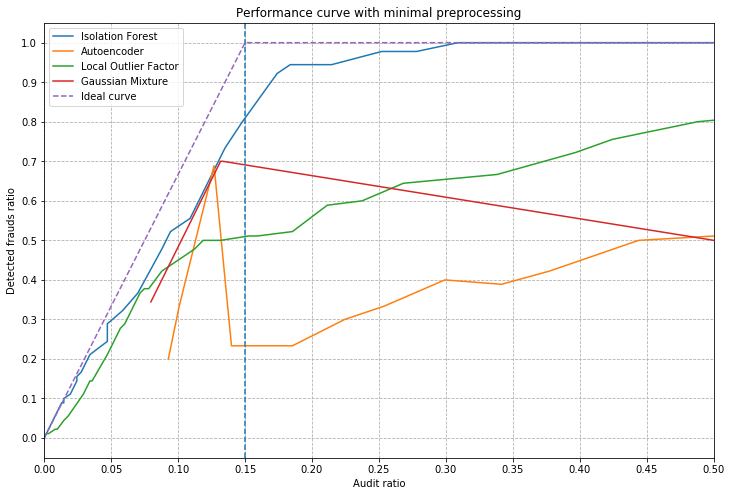

In [21]:
# Get performance curves with minimal preprocessing
threshold_range = np.logspace(np.log10(0.001), np.log10(0.5))

if_performance_curve_test = get_performance_curve(X_train, X_test, y_test, threshold_range, predict_isolation_forest, model_fn=fit_isolation_forest)
lof_performance_curve_test = get_performance_curve(X_train, X_test, y_test, threshold_range, predict_local_outlier_factor, model_fn=fit_local_outlier_factor, model_args=[20])
gm_curve_test = get_performance_curve(X_train, X_test, y_test, threshold_range, predict_gaussian_mixture, model_fn=fit_gaussian_mixture)
ae_performance_curve_test = get_performance_curve(X_train, X_test, y_test, threshold_range, predict_autoencoder, model_fn=fit_autoencoder, model_args=[0.0001, 300])

# Plot performance curves
plot_all_performance_curves(if_performance_curve_test, ae_performance_curve_test, lof_performance_curve_test, gm_curve_test, 'Performance curve with minimal preprocessing')